In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sys
sys.path.append('..')
from NrnResponse import *
from NSclasses import *
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation
from matplotlib.animation import FuncAnimation, PillowWriter 
import seaborn as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## nxn Macro grid

In [8]:
def getMacroGrid(nodes):
    #generate a MacroGrid for nxn spatial preferences
    assert(nodes >= 3)
    
    Grid = Mygrid(1, 1, 50, 50)
    #Xgrid and Ygrid within [-1, 1]x[-1, 1] 
    Xspace = np.linspace(-1+0.5, 1-0.5, num=nodes, endpoint=True)
    Yspace = np.linspace(-1+0.5, 1-0.5, num=nodes, endpoint=True)
    h = Xspace[1] - Xspace[0]
    
    MacroNeurons = [0]*(nodes**2)
    for i in range(nodes):
        for j in range(nodes):
            x = Xspace[i]
            y = Yspace[j]
            MacroNeurons[i+j*nodes] = MyNrn(x, y, 
                                             4*np.pi/9, Grid)
            #orientation preference defined based on index (=4) in 3x3 micro grid
    return MacroNeurons, Grid, h

## 3x3 Micro grid

In [9]:
'''Creates 3x3 Micro grid'''
def getMicroGrid(Neuron, h, Grid, micro = 3):
    #for a neuron in the MacroGrid
    #generate 8 surrounding MicroGrid neurons
    #return a 3x3 matrix
    MicroNeurons = [([0]*micro) for i in range(micro)] #fix 3x3
    diff = h/micro
    x, y, the = Neuron.out()
    for i in range(micro):
        for j in range(micro):
            MicroNeurons[j][i] = MyNrn(x+(j-1)*diff, y+(1-i)*diff, 
                                (j+i*micro)*np.pi/(micro**2), Grid)
            
    temp = MicroNeurons[1][1]
    temp_x, temp_y, temp_the = temp.out()
    assert(x == temp_x and y == temp_y and the == temp_the)
    return MicroNeurons


def MicroGridPlot(neurons):
    num = len(neurons)
    X = np.linspace(neurons[0].x -0.5, neurons[-1].x +0.5, 
                         num=50, endpoint=True)
    Y = np.linspace(neurons[0].y +0.5, neurons[-1].y -0.5, 
                         num=50, endpoint=True)
    Z = np.zeros((50, 50))
    
    x = [0]*num
    y = [0]*num
    for i in range(num):
        x[i] = neurons[i].x
        y[i] = neurons[i].y
    
    return x, y

## Neuron Grid

In [10]:
'''Creates the Neuron Grid'''
import pdb

def getNeuronGrid(nodes, micro = 3, flag=0):
    """
    Nick's version
    """
    allNeurons = []
    assert(nodes >= 3)
    
    Grid = Mygrid(1, 1, 50, 50)
    #Xgrid and Ygrid within [-1, 1]x[-1, 1] 
    Xspace = np.linspace(-1+0.5, 1-0.5, num=nodes, endpoint=True)
    Yspace = np.linspace(-1+0.5, 1-0.5, num=nodes, endpoint=True)
    h = Xspace[1] - Xspace[0]
    orientations = np.linspace(0, np.pi, 9)
    
    allNeurons = []
    for i in range(nodes):
        for micro_i in range(micro):
            for j in range(nodes):
                for micro_j in range(micro):
                    micro_n = micro*(micro_i) + micro_j
                    # i will end up as the row dimension, which is actually y
                    # similarly, j will end up as the col dimension, which is actually x
                    x = Xspace[j]
                    y = Yspace[i]
                    neuron = MyNrn(x, y, orientations[micro_n], Grid)
                    allNeurons.append(neuron)
    return allNeurons, h    


def getNeuronGridBad(nodes, micro = 3, flag = 0):
    """
    Deprecated old version
    """
    #nodes = number of neurons in the MacroGrid
    
    MacroNeurons, Grid, h = getMacroGrid(nodes)
    allNeurons = [0] * (nodes**2 * micro**2)    
    
    MatrixNeuron = getMicroGrid(MacroNeurons[0], h, Grid, micro = micro)
    for j in range(1,nodes):
        temp = getMicroGrid(MacroNeurons[j], h, Grid)
        MatrixNeuron = np.vstack((temp, MatrixNeuron))
    
    for i in range(1,nodes):
        temp_col = getMicroGrid(MacroNeurons[i*nodes], h, Grid)
        for j in range(1,nodes):
            temp = getMicroGrid(MacroNeurons[j+i*nodes], h, Grid)
            temp_col = np.vstack((temp, temp_col))
        MatrixNeuron = np.hstack((MatrixNeuron, temp_col))
    
    allNeurons = np.reshape(MatrixNeuron, (1, nodes**2 * micro**2))[0]
    
    
    if (flag == 100): #plot micro-grid neuron centers
        allNeurons = np.flip(allNeurons)
        fig, axes = plt.subplots(nodes,nodes,figsize = [9,8])
        
        for i in range(nodes):
            for j in range(nodes):
                ax = axes[i,j]
                r = i*micro
                c = j*nodes*micro**2
                temp1 = allNeurons[r+c:r+c+micro]
                temp1 = np.transpose(temp1)
                temp2 = allNeurons[r+c+nodes*micro:r+c+nodes*micro+micro]
                temp2 = np.transpose(temp2)
                temp3 = allNeurons[r+c+nodes*micro*2:r+c+nodes*micro*2+micro]
                temp3 = np.transpose(temp3)
                temp = np.hstack((temp1, temp2, temp3))
                x, y = MicroGridPlot(temp)
                ax.set_xlim(-1, 1)
                ax.set_ylim(-1, 1)
                cl = ['b']*micro**2
                cl[micro+1] = 'r'
                ax.scatter(x, y, color =cl, alpha=0.5)
        fig.tight_layout()
        st = fig.suptitle('{2}x{3} MicroGrid in {0}x{1} MacroGrid'.format(nodes,
                          nodes, micro, micro), 
              fontsize = 16)
        st.set_y(0.95)
        fig.subplots_adjust(top=0.9)
        allNeurons = np.flip(allNeurons)
        
    return allNeurons, h/3, MacroNeurons

# doesn't work when micro!=3
neur_grid, _, = getNeuronGrid(3, micro=3, flag = 100)
# neur_grid, _, _ = getNeuronGridBad(3, micro=3, flag = 100)

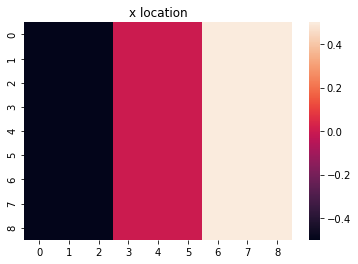

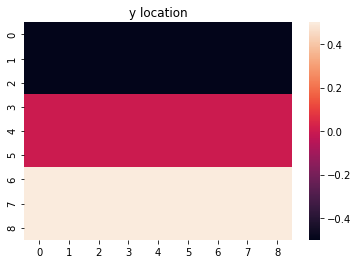

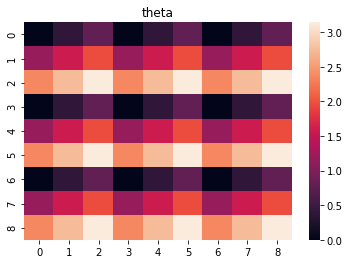

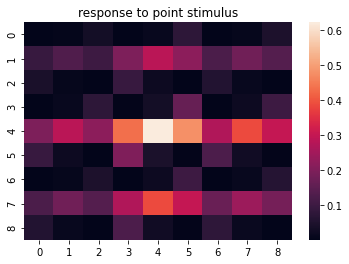

In [11]:
# some sanity checks to make sure the full grid looks right
resps = []
for ii in range(len(neur_grid)):
    resps.append(neur_grid[ii].x)
sns.heatmap(np.array(resps).reshape(9,9))
plt.title('x location')
plt.show()

resps = []
for ii in range(len(neur_grid)):
    resps.append(neur_grid[ii].y)
sns.heatmap(np.array(resps).reshape(9,9))
plt.title('y location')
plt.show()

resps = []
for ii in range(len(neur_grid)):
    resps.append(neur_grid[ii].theta)
sns.heatmap(np.array(resps).reshape(9,9))
plt.title('theta')
plt.show()

resps = []
for ii in range(len(neur_grid)):
#     print(MacroNeurons[ii])
    resp = NrnResponse(neur_grid[ii],  MyPtStm(0,0, np.pi/2), neur_grid[ii].grid)
    resps.append(resp)
sns.heatmap(np.array(resps).reshape(9,9))
plt.title('response to point stimulus')
plt.show()


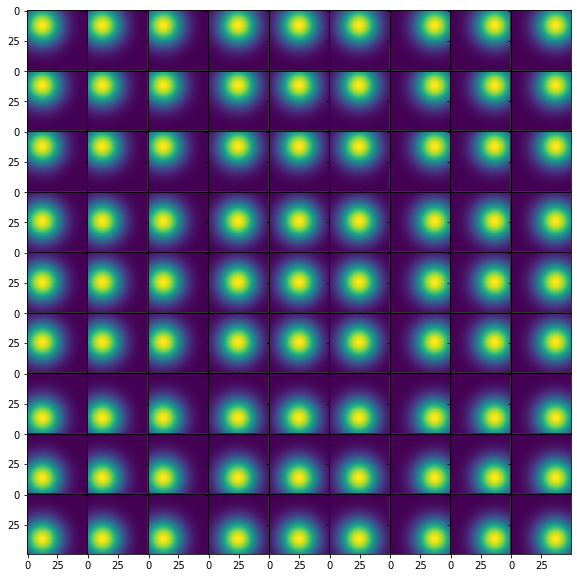

In [12]:
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
neur_grid_curves = [neur_grid[ii].PosCurve() for ii in range(81)]

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(9, 9),  # creates 2x2 grid of axes
                 axes_pad=0.01,  # pad between axes in inch.
                 )

for ax, im in zip(grid, neur_grid_curves):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

## Util functions

In [22]:
def CircularRFwt(target, neurons, radius=0.5):
    #target: input neuron to generate weights w.r.t others
    #neurons: the list of all other neurons in the same pool as the target
    N = len(neurons)
    r = min(target.grid.xylim)*radius #radius = quarter of box side length
    tar_x, tar_y = target.x, target.y
    weight = np.zeros(N)
    #neuron i in the list has weight i
    count = 0
    for i in range(N):
        n_x, n_y = neurons[i].x, neurons[i].y
        dist = np.sqrt((tar_x-n_x)**2+(tar_y-n_y)**2)
#         pdb.set_trace()
        if dist > r:
            weight[i] = 0
        else:
            count = count + 1
            weight[i] = 1 - dist/r
            
    if count == 0:
        count = count + 1
#     pdb.set_trace()
    #return weight/count this part needs debugging
    return weight/(weight.sum())

def WtResponse(response, weight):
    #returns the sum of weighted responses in the neuron pool
    assert(len(response) == len(weight))
    #response from neuron i is assigned with weight i
    return sum(weight*response)



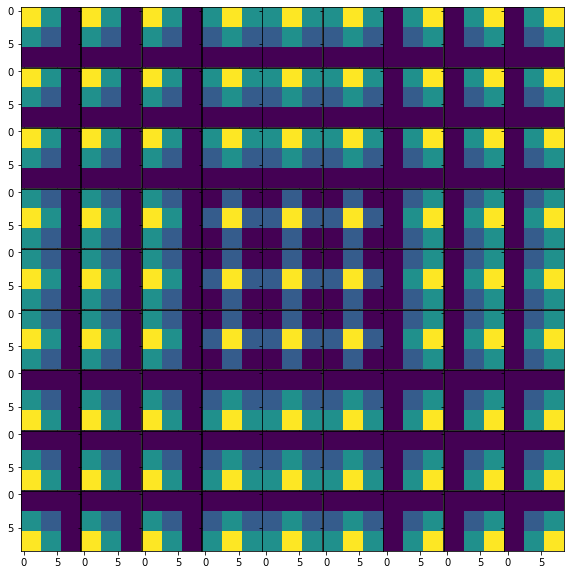

In [25]:
neur_grid_curves = [CircularRFwt(neuron, neur_grid, radius=1).reshape(9,9) for neuron in neur_grid]
# counts = [CircularRFwt(neuron, neur_grid, radius=1)[1] for neuron in neur_grid]
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(9, 9),  # creates 2x2 grid of axes
                 axes_pad=0.01,  # pad between axes in inch.
                 )

for ax, im in zip(grid, neur_grid_curves):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

array([[0.04845891, 0.04845891, 0.04845891, 0.02422946, 0.02422946,
        0.02422946, 0.        , 0.        , 0.        ],
       [0.04845891, 0.04845891, 0.04845891, 0.02422946, 0.02422946,
        0.02422946, 0.        , 0.        , 0.        ],
       [0.04845891, 0.04845891, 0.04845891, 0.02422946, 0.02422946,
        0.02422946, 0.        , 0.        , 0.        ],
       [0.02422946, 0.02422946, 0.02422946, 0.01419329, 0.01419329,
        0.01419329, 0.        , 0.        , 0.        ],
       [0.02422946, 0.02422946, 0.02422946, 0.01419329, 0.01419329,
        0.01419329, 0.        , 0.        , 0.        ],
       [0.02422946, 0.02422946, 0.02422946, 0.01419329, 0.01419329,
        0.01419329, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],


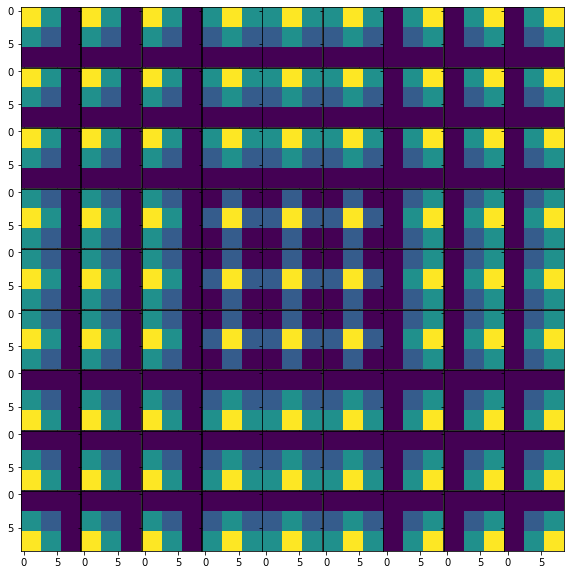

In [18]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(9, 9),  # creates 2x2 grid of axes
                 axes_pad=0.01,  # pad between axes in inch.
                 )

for ax, im, count in zip(grid, neur_grid_curves, counts):
    # Iterating over the grid returns the Axes.
    ax.imshow(im*count)

plt.show()

In [58]:
def GetRes(nodes, neurons, stimu, Grid, micro = 1):
    '''Obtain input response for all neurons'''
    res = np.zeros(nodes**2*(micro**2))
    for i in range(len(res)):
        res[i] = NrnResponse(neurons[i], stimu, Grid)
    return res

def WeightRes(nodes, neurons, responses, micro = 1, radius=0.5):
    '''Obtain weighted-sum response for all neurons
    Extract weights for each neuron: weight
    Compute weighted sum: res'''
    #responses = all responses from input/last step
    
    res = np.zeros(nodes**2*(micro**2))
    for i in range(len(res)):
        target = neurons[i]
        rest_neurons = np.delete(neurons,i)
        rest_res = np.delete(responses,i)
        weight = CircularRFwt(target, rest_neurons, radius=radius)
        res[i] = WtResponse(rest_res, weight)
    return res

def NormalizeRes(nodes, neurons, responses, z, micro = 1, **kwargs):
    '''Normalization step1:
    Extract single neuron response: i_tar
    Extract pooled neurons weighted responses: i_pool'''
    #responses = all responses from input/last step
    #z = weighted-sum responses for all neurons

    res = np.zeros(nodes**2*(micro**2))
    for i in range(len(res)):
        i_pool = z[i]
        i_tar = responses[i]
        res[i] = NormalizedR(i_tar, i_pool, **kwargs)
    return res

def NormalizedR(ini, ini_m, gamma = 1, sigma = 0, exp = 1):
    '''Normalization step2:
    Normalize single neuron's response'''
    #ini = target neuron's response
    #ini_m = other neurons' responses (weighted sum)
    nom = ini**exp
    denom = sigma**exp + ini_m**exp + nom
    return gamma* (nom/denom)

def ToMatrix(nodes,arr, micro = 1):
    '''Reshape an array of responses into matrix'''
    res = np.reshape(arr, (nodes*micro, nodes*micro))

    return res

def getGlobalAxis(Xspace, Yspace):
    '''Reconstruct the [-1,1]x[-1,1] global grid'''
    hx = Xspace[1]-Xspace[0]
    Xleft = np.arange(-1, Xspace[0], hx)
    Xright = np.arange(Xspace[-1], 1, hx)
    #global X axis
    GX = np.hstack([Xleft[:-1], Xspace, Xright[1:]])
    
    Xleft_ind = len(Xleft)-1
    Xright_ind = len(Xleft)+len(Xspace)-1-1
    
    hy = Yspace[1]-Yspace[0]
    Yleft = np.arange(-1, Yspace[0], hy)
    Yright = np.arange(Yspace[-1], 1, hy)
    #global Y axis
    GY = np.hstack([Yleft[:-1], Yspace, Yright[1:]])
    
    Yleft_ind = len(Yleft)-1
    Yright_ind = len(Yleft)+len(Yspace)-1-1
    
    return [Xleft_ind, Xright_ind], [Yleft_ind, Yright_ind], GX, GY

## Initialization for Time Model

In [59]:
def MicroInitialization(nodes, micro = 1):
    assert(nodes >= 4)
    
    Grid = Mygrid(1, 1, 50, 50)

    neurons, h = getNeuronGrid(nodes, micro = 3, flag = 0)
#     neurons, h, _ = getNeuronGridBad(nodes, micro = 3, flag = 0)
    
    #Xgrid and Ygrid within [-1, 1]x[-1, 1] 
    Xspace = np.linspace(-1+0.5-h, 1-0.5+h, 
                         num=nodes*micro, endpoint=True)
    Yspace = np.linspace(-1+0.5-h, 1-0.5+h, 
                         num=nodes*micro, endpoint=True)
    
    return Xspace, Yspace, neurons, Grid

Xspace, Yspace, neurons, Grid = MicroInitialization(6, 3)

In [60]:
### Iteration in time model ver.1.2 ###

def TimeModelwithMicro(number, total, time_off, 
                       micro = 1, radius=0.5, 
                       stim_x=0, stim_y=0, stim_theta=np.pi/2,
                       gamma = 1, sigma = 0, exp = 1,
                      ):
    T = total 
    nodes = number
    Sti = MyPtStm(stim_x, stim_y, stim_theta) #initial point stimulus
    S_t = []
    T_on = 0; T_off = time_off
    for i in range(T):
        if (i < T_off):
            S_t.append(Sti)
        else:
            S_t.append(0)
    #initialization here
    Xspace, Yspace, neurons, Grid = MicroInitialization(nodes, 
                                                    micro = micro)
    X = []
    Y = []

    if S_t[0] != 0:
        X.append(GetRes(nodes, neurons, S_t[0], Grid, micro))
        z = WeightRes(nodes, neurons, X[0], micro, radius=radius)
    else:
        X.append(np.zeros(nodes**2*(micro**2))) #new
        z = 0
    Y.append(NormalizeRes(nodes, neurons, X[0], z, micro, gamma=gamma, sigma=sigma, exp=exp))
    for i in range(1,T):
        if S_t[i] != 0:
            X.append(GetRes(nodes, neurons, S_t[i], Grid, micro))
            z =  WeightRes(nodes, neurons, X[i]+Y[i-1], micro, radius=radius) #update
        else:
            X.append(np.zeros(nodes**2*(micro**2))) #new
            z = WeightRes(nodes, neurons, Y[i-1], micro, radius=radius)
        Y.append(NormalizeRes(nodes, neurons, Y[i-1]+X[i], z, micro, gamma=gamma, sigma=sigma, exp=exp)) #update
        
    
    return Xspace, Yspace, Y, X

In [61]:
def run(n, t_total, t_off, **kwargs):
    Xspace, Yspace, Y, X = TimeModelwithMicro(n, t_total, t_off, **kwargs)
    Xind, Yind, GbX, GbY = getGlobalAxis(Xspace, Yspace)
    Xleft = Xind[0]; Xright = Xind[1];
    Yleft = Yind[0]; Yright = Yind[1];
    N = len(Y)
    MatrixY = []
    
    for i in range(N):
        container = np.zeros((len(GbX),len(GbY)))
        container[Xleft:Xright+1, Yleft:Yright+1] = ToMatrix(n,Y[i], micro = 3)
#         container[Xleft:Xright+1, Yleft:Yright+1] = ToMatrix(n,X[i], micro = 3)
        MatrixY.append(container)
    return GbX, GbY, MatrixY, Y
#     return GbX, GbY, MatrixY, X



In [64]:
GbX, GbY, MatrixY, Y = run(4, 30, 10, 
                            micro = 3, radius=1, 
                            stim_x=0.75, stim_y=0, stim_theta=np.pi/2,
                            gamma = 1, sigma = 1, exp = 2,
                          )


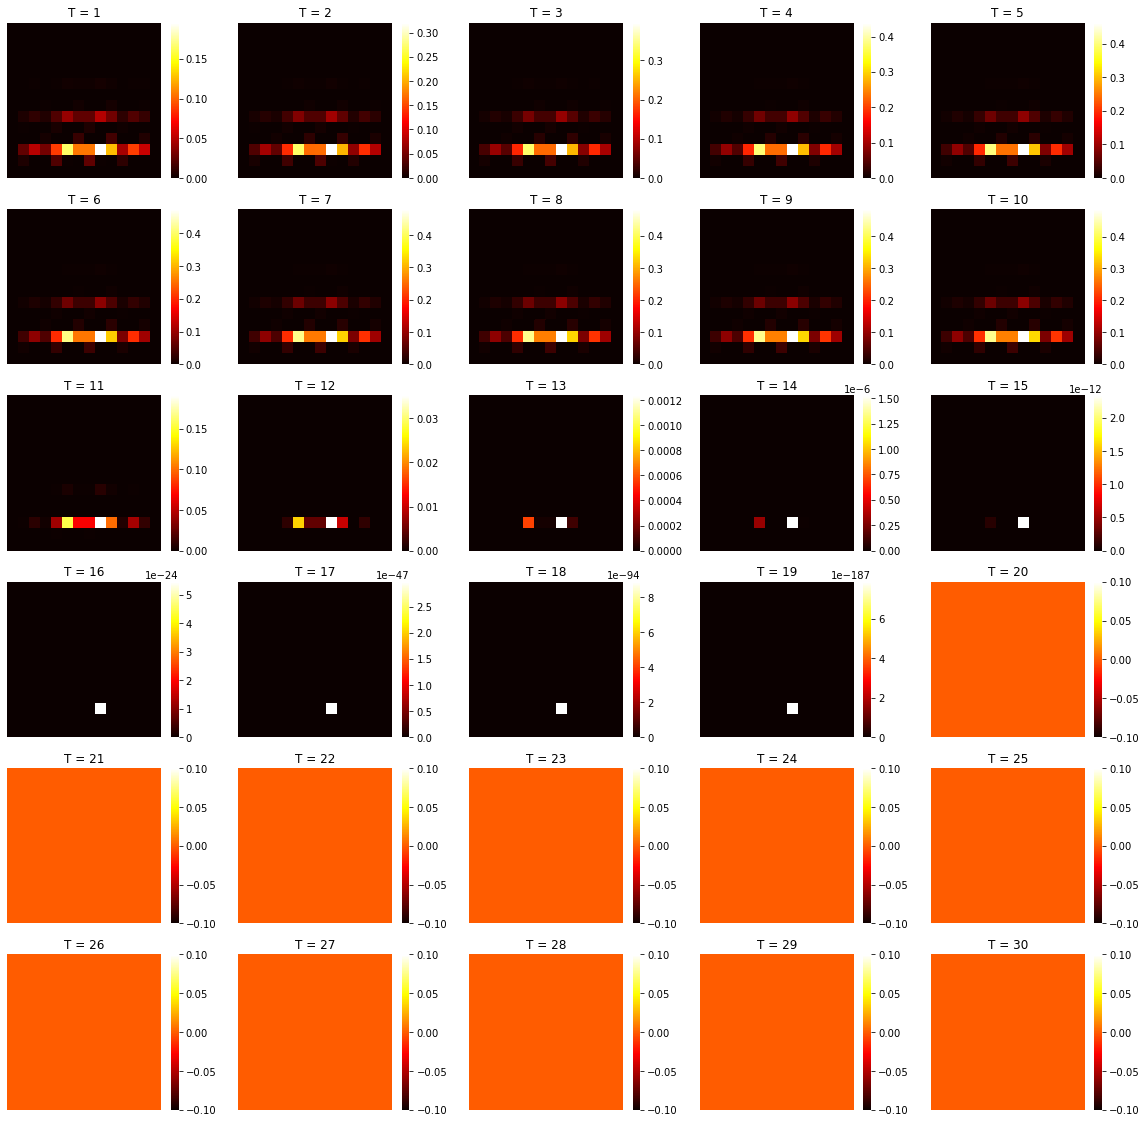

In [65]:
def MatrixPlot(Xspace, Yspace, MatrixY, flag):
    N = len(MatrixY)

    fig, axes = plt.subplots(int(N/5), 5, figsize = [20,20])
    if flag == 1 :#contour plot
        for i in range(N):
            ax = axes[int(i/5),(i%5)]
            ax.axis('off')
            ax.title.set_text('T = {}'.format(i+1))

            #add colorbar
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)

            im = ax.contourf(Xspace, Yspace, MatrixY[i],  cmap='hot')
            fig.colorbar(im, cax=cax, orientation='vertical')
            
    if flag == 2 :#seaborn heatmap plot
        i = 0
        for ax in axes.flat:
            ax.axis('off')
            ax.title.set_text('T = {}'.format(i+1))
            sns.heatmap(MatrixY[i],ax=ax, cmap='hot', cbar=True)
            i += 1
            
    plt.show()
            
MatrixPlot(GbX, GbY, MatrixY, 2)

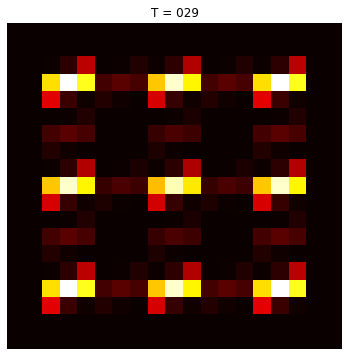

In [39]:
%matplotlib inline
def getAnimation(Xspace, Yspace, MatrixY, flag):


    fr = len(MatrixY)
    fig,ax = plt.subplots(figsize = (6,6))
    def animate(i):
        ax.clear()
        ax.axis('off')
#         p?db.set_trace()
        if flag == 1: #contour plot
            ax.contourf(Xspace, Yspace, MatrixY[i], cmap='hot')
        if flag == 2: #seaborn heatmap
            sns.heatmap(MatrixY[i], cmap='hot', ax=ax, cbar=False)
        ax.set_title('T = %03d'%(i)) 

        
    ani =  matplotlib.animation.FuncAnimation(fig,animate,frames=fr,
                                              interval=200,blit=False)

    ani.save('testtt.gif',  writer='pillow', fps=10)
#     ani.show()
    
getAnimation(GbX, GbY, MatrixY, 2)